# Receiver Operator Characteristic (ROC) Analysis - APACHE IV

## 1. ETL for ROC curve analysis

In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from imblearn.metrics import classification_report_imbalanced
from scipy import stats
import seaborn as sns

In [56]:
# Bringing the patient survival datset into notebook
database_a_4 = pd.read_csv("Raw_dataset_IV.csv")

In [57]:
# Dropping height and weight 
database_apache_4 = database_a_4.drop(['height', 'weight'], axis=1)

In [126]:
# Counting columns with more than 25000 missing values
missing_value_fields = database_apache_4.isnull().sum(axis=0).sort_values(ascending=False)[database_apache_4.isnull().sum(axis=0).sort_values(ascending=False) > 45000]

print("\nTotal features with more than", 45000, "missing values:", len(missing_value_fields))


Total features with more than 45000 missing values: 3


In [127]:
# Dropping columns with more than 25000 missing values
database_apache_4.drop(missing_value_fields.index.tolist(), axis=1, inplace = True)

In [128]:
# Identifying columns with 'object' data type
object_list = database_apache_4.select_dtypes(include = "object").columns
print (object_list)

Index([], dtype='object')


In [129]:
# Encoding columns with 'object' data type
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feat in object_list:
    database_apache_4[feat] = le.fit_transform(database_apache_4[feat].astype(str))

In [130]:
# Dropping rows(patients) with missing values in any column
database_roc_IV = database_apache_4.dropna()

In [131]:
database_roc_IV

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,hospital_admit_source,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.730000,0,2,1,4,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,9,0
1,114252,59342,81,0,77.0,27.420000,0,2,0,4,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8,6
5,33181,74489,83,0,67.0,27.560000,0,2,1,2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7,4
9,42871,90749,118,0,50.0,25.710000,0,6,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
17,22471,112115,118,0,46.0,25.845717,0,3,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91692,125145,56872,30,0,36.0,20.575852,0,2,0,15,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5,3
91698,83806,68549,195,0,47.0,51.439842,1,2,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
91706,127138,59223,121,0,54.0,19.770448,0,4,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
91709,66119,13486,121,0,56.0,47.179671,0,2,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,0


In [132]:
# Converting df to csv
database_roc_IV.to_csv('database_roc_IV.csv')

## 2. ROC Curve Plotting and AUC Calculation

In [134]:
# Defining the predictor variables and the response variable
X = database_roc_IV[['temp_apache', 'map_apache', 'heart_rate_apache', 'resprate_apache', 
                  'sodium_apache', 'd1_potassium_max', 'd1_potassium_min', 'creatinine_apache', 
                  'hematocrit_apache', 'wbc_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache', 
                  'age', 'elective_surgery', 'apache_post_operative', 'ventilated_apache', 'bun_apache',
                    #'urineoutput_apache', 
                     #'bilirubin_apache', 
                     #'paco2_apache', 'paco2_for_ph_apache', 'pao2_apache', 'ph_apache', 
                     #'albumin_apache', 
                     'glucose_apache', 'apache_2_diagnosis', 
                    'icu_admit_source', 'pre_icu_los_days', 'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
                    'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis']]
y = database_roc_IV['hospital_death']

# Splitting the dataset into training (70%) and testing (30%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=0) 

# Instantiating the model
log_regression_apache_4 = LogisticRegression()

# Fitting the model using the training data
log_regression_apache_4.fit(X_train,y_train)


/Users/brianbutler/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

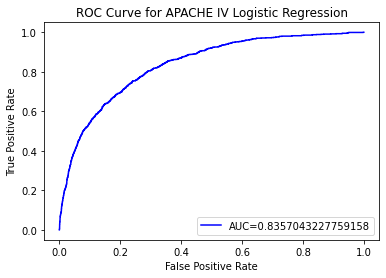

In [135]:
# Defining metrics
y_pred_proba = log_regression_apache_4.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Creating ROC curve
plt.plot(fpr,tpr,color='blue',label="AUC="+str(auc))
plt.title('ROC Curve for APACHE IV Logistic Regression')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()